# Mastercard share price forecast

We create different models that try to predict the price of Mastercard shares.

# Data

- Date - date
- Open - opening price
- High - maximum price
- Low - minimum price
- Close - closing price
- Volume - traded amount of shares
- Dividens - Dividends paid
- Stock Splits - A stock split is a situation where a company increases the number of its outstanding shares to increase their liquidity.


We will use the High column for predictions.

# Data retrieval and data analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's read the data and throw away the unnecessary columns right away.

In [ ]:
dataset = pd.read_csv("..\dataset\Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)

In [ ]:
dataset.head()

In [ ]:
dataset.describe()

In [ ]:
dataset.isna().sum()

Rendering of the share development chart
* We will use 2016 and 2020 data for learning
* For model validation we will use data from 2021

In [ ]:
trainig_start = 2016
training_end = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{trainig_start}":f"{training_end}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{training_end + 1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Před {tend+1})", f"Test ({tend+1} a dále)"])
    plt.title("Cena akcí MasterCard")
    plt.show()

train_test_plot(dataset,trainig_start,training_end)

# Data preparation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Division of data into training and test data.

- Training data are from 2016 to 2021. 
- Testing data are for 2021.

In [ ]:
trainig_start = 2016
training_end = 2020

def train_test_split(dataset, trainig_start, training_end):
    train = dataset.loc[f"{trainig_start}":f"{training_end}", "High"].values
    test = dataset.loc[f"{training_end+1}":, "High"].values
    return train, test

training_data, testing_data = train_test_split(dataset, trainig_start, training_end)

In [ ]:
print (f"Training data shape {training_data.shape}")
print (f"Testing data shape {testing_data.shape}")

Control display of input data

In [ ]:
training_data[0]

To standardize the training set, we use the MinMaxScaler function to help us avoid outliers or anomalies. 

You can also try using the StandardScaler function or any other scalar function to normalize the data and improve the model performance.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_data = training_data.reshape(-1, 1)
training_data_scaled = sc.fit_transform(training_data)

Control display of the first standardized share price

In [ ]:
training_data_scaled[0]

The split_sequence function uses the training dataset and converts it into inputs (x_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and n_step is three, then it converts the sequence into three input timestamps and one output.

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 80
features = 1

X_train, y_train = split_sequence(training_data_scaled, n_steps)



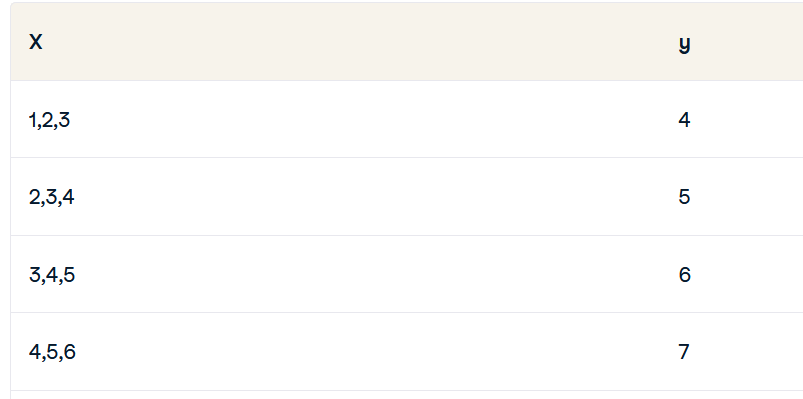

Control matrix shape display

In [ ]:
print (X_train.shape)
print (y_train.shape)

Control display of training data

In [ ]:
X_train[0]

Control display of output data

In [ ]:
y_train[0]

We are working with univariate series, so the number of functions is one, and we need to reshape the X_train to fit the LSTM model. 

X_train has [samples, timesteps] and we will transform it to [samples, timesteps, features].

In our case, features = 1

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

Edit training data

In [ ]:
inputs = testing_data
inputs = inputs.reshape(-1, 1)

# standardization

inputs = sc.transform(inputs)

# Splitting data
X_test, y_test = split_sequence(inputs, n_steps)

# Reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

# Simple RNN
The first model will be a simple recurrent neural network.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input

Again, it will be a sequential network.

In [ ]:
model_simple = Sequential()

The input data has the following dimensions:
* features = 1, one variable
* n_steps = 80, a series of 80 input values

In [ ]:
model_simple.add(Input(shape=(n_steps, features))) 

You can experiment with the number of units, as more units will give you better results. 

* units
* activation

In [ ]:
model_simple.add(SimpleRNN(units=125,                          
                           activation="tanh",                 
                           ))  

Then add an output layer that returns a single value.

In [ ]:
model_simple.add(Dense(units=1))

Printing of the network structure.

In [ ]:
model_simple.summary()

Setting learning parameters

In [ ]:
model_simple.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])

Creating earlystops

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

Neural network learning

In [ ]:
history_simple=model_simple.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

View learning history

In [ ]:
plt.plot(history_simple.history['loss'], label='Train Loss')
plt.plot(history_simple.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss and MAE')
plt.ylabel('Loss and MAE')
plt.xlabel('Počet epoch')
plt.show()

Model validation

Prediction of future share values

In [ ]:
predicted_stock_price = model_simple.predict(X_test)

Inversion of result from standardized value to actual

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

RMSE - deviations of actual and predicted values

In [ ]:
def return_rmse(test, predicted):    
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("RMSE {:.2f}.".format(rmse))
    
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

Chart display

In [ ]:
def plot_predictions(test, predicted):
    """ Rendering of predicted and actual action values 
    """
    
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)

# LTSM neural network

In [ ]:
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.optimizers import SGD

The model consists of one hidden LSTM layer and an output layer. 

You can experiment with the number of units, as more units will give you better results. 

For this experiment, we set the number of LSTM units to 125 as the tanh activation and set the input size.

Finally, we build the model using the RMSprop optimizer and the mean square error as a loss function.

In [ ]:
model_ltsm = Sequential()
model_ltsm.add(Input(shape=(n_steps, features))) 
model_ltsm.add(LSTM(units=125, activation="tanh"))
model_ltsm.add(Dense(units=1))

Viewing the network structure.

In [ ]:
model_ltsm.summary()

Network Compilation and Training

In [ ]:
model_ltsm.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

In [ ]:
history_ltsm=model_ltsm.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

View learning history

In [ ]:
plt.plot(history_ltsm.history['loss'], label='Train Loss')
plt.plot(history_ltsm.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss, MAE')
plt.ylabel('Loss, MAE')
plt.xlabel('Počet epoch')
plt.show()

Validation of the LTSM model

In [ ]:
predicted_stock_price = model_ltsm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)

# Model GRU
Model based on Gated Recurrent Unit.

In [ ]:
model_gru = Sequential()
model_gru.add(Input(shape=(n_steps, features))) 
model_gru.add(GRU(units=125, activation="tanh"))
model_gru.add(Dense(units=1))

Viewing the network structure

In [ ]:
model_gru.summary()

Neural network training

In [ ]:
model_gru.compile(optimizer="RMSprop", loss="mse", metrics=['mae'])
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=30)

In [ ]:
history_gru=model_gru.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

View learning history

In [ ]:
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['mae'], label='Train MAE')
plt.legend(loc="right")
plt.title('Loss, MAE')
plt.ylabel('Loss, MAE')
plt.xlabel('Počet epoch')
plt.show()

Verification of the GRU model

In [ ]:
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
return_rmse(testing_data[0:y_test.shape[0]], predicted_stock_price)

In [ ]:
plot_predictions(testing_data[0:y_test.shape[0]], predicted_stock_price)